In [1]:
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html


def opinion_diff(u, v, G):
    return G.nodes[u]['opinion'] - G.nodes[v]['opinion']


def update_opinions(u, v, G, convergence, symmetric_updating=True):
    diff = opinion_diff(u, v, G)

    G.nodes[u]['opinion'] -= convergence * diff
    
    if symmetric_updating:
        G.nodes[v]['opinion'] += convergence * diff
    return G

        
def update_effective_net(u, v, effective_net, G, threshold, symmetric_updating):
    # update u's neighbors
    for w in G.neighbors(u):
        diff = abs(opinion_diff(u, w, G))
        
        if diff <= threshold and not effective_net.has_edge(u, w):
            effective_net.add_edge(u, w)

        elif diff > threshold and effective_net.has_edge(u, w):
            effective_net.remove_edge(u, w)
        
    if not symmetric_updating:
        return effective_net
    
    # update v's neighbors
    for w in G.neighbors(v):
        diff = abs(opinion_diff(u, w, G))
        
        if diff <= threshold and not effective_net.has_edge(v, w):
            effective_net.add_edge(v, w)

        elif diff > threshold and effective_net.has_edge(v, w):
            effective_net.remove_edge(v, w)
    return effective_net


def simulate_deffuant_model(G: nx.Graph, iterations: int, threshold: float,\
                            convergence: float, symmetric_updating=True, fast_mode=False):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize node attributes
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.uniform(0, 1)

    # get initial effective network
    effective_net = copy.deepcopy(G)
    
    # remove edges between nodes with opinion difference above threshold
    for u, v in effective_net.edges:
        if abs(opinion_diff(u, v, G)) > threshold:
            effective_net.remove_edge(u, v)

    if not fast_mode:
        # initialize the list of nets that will be returned
        effective_networks = [effective_net]

    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = copy.deepcopy(effective_networks[t-1])
        
        # choose random node to update
        u = np.random.choice(G.order())
        
        # get another node if u is isolated
        while not list(effective_net.neighbors(u)):
            u = np.random.choice(G.order())
        
        # get a random neighbor of u
        v = np.random.choice(list(effective_net.neighbors(u)))

        # update their opinions
        G = update_opinions(u, v, G, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, G, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            effective_networks.append(effective_net)
    
    if not fast_mode:
        return effective_networks
    else:
        return effective_net

In [2]:
# metrics functions

# equation 3 in the paper
def dispersion_index(G):
    return sum([len(cluster)**2 for cluster in nx.connected_components(G)])/(G.order()**2)

def avg_dispersion_data(case, order, iterations, sample_size, points, init_d, final_d, convergence):
    avg_dispersions = [0 for i in range(points)]
    d = [init_d + i*(final_d-init_d)/points for i in range(points)]
    
    for i in range(points):
        print(".", end='')
        for j in range(sample_size):
            
            # generate network sample
            if case == 'scale_free':
                net = nx.barabasi_albert_graph(n=order, m=2, seed=42, initial_graph=nx.complete_graph(3))
            elif case == 'complete_mixing':
                net = nx.complete_graph(n=order)
            elif case == 'lattice':
                net = nx.grid_2d_graph(int(np.sqrt(order)), int(np.sqrt(order)), periodic=False)
            else:
                return None

            final_net = simulate_deffuant_model(net, iterations, d[i], convergence, fast_mode=True)
            avg_dispersions[i] += dispersion_index(final_net)
    
    print()
    avg_dispersions = [dispersion_sum/sample_size for dispersion_sum in avg_dispersions]
        
    return d, avg_dispersions

.........................


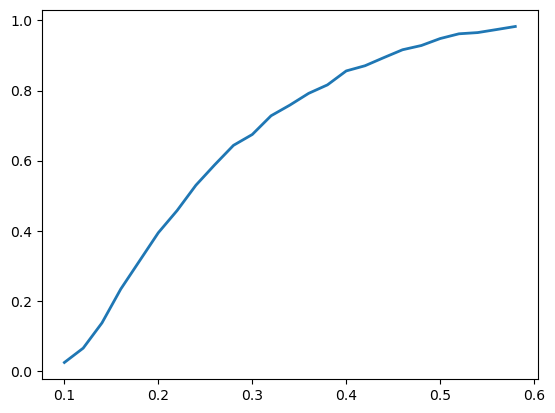

In [4]:
#plt.style.use('_mpl-gallery')

# data
x, y = avg_dispersion_data('scale_free', order=900, iterations=1000, sample_size=20,\
                           points=25, init_d=0.1, final_d=0.6, convergence=0.3)

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

plt.show()

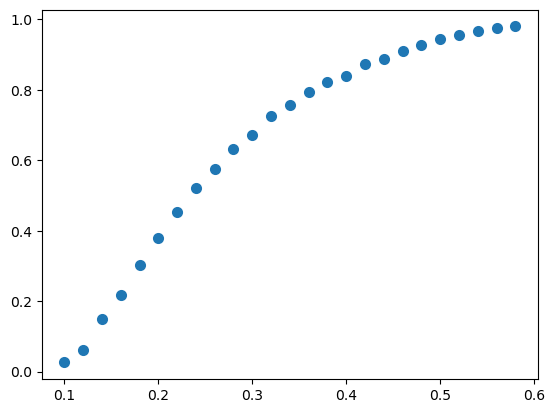

In [89]:
# plot
fig, ax = plt.subplots()

ax.scatter(x, y, linewidth=2.0)

plt.show()

In [5]:
# we set n=900 in the BA graph so that it has the same amount of vertices as the 30x30 grid graph
# we set m=2 so that the average degree of the graph is 2*|E|/n = 2*(3+2*897)/900 ~= 4 as in the grid graph

BA_graph = nx.barabasi_albert_graph(n=900, m=2, seed=42, initial_graph=nx.complete_graph(3))
lattice  = nx.grid_2d_graph(30, 30, periodic=False, create_using=None)

In [6]:
start = time.time()

effective_networks = simulate_deffuant_model(BA_graph, 1000, 0.3, 0.3, fast_mode=False)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

simulation time: 8.182 seconds


In [6]:
#nx.draw(res[-1], nx.spring_layout(res[-1]))

In [4]:
print(nx.__version__)

2.8.8


In [77]:
G = nx.Graph()
G.add_edge(1,2)

G.nodes[1]['a'] = 42
print(G.nodes[1]['a'])

def change(n, key, val, G):
    G.nodes[n][key] = val
    
change(1,'a', 43, G)

print(G.nodes[1]['a'])

42
43


In [78]:
G.order()

2